In [1]:
#imports 

import pandas as pd
from matplotlib import pyplot as plt
import re

In [2]:
#reading wti oil price file

oilprice = pd.read_csv('data/oil_price.csv')[['Date','Price']]

oilprice['Date'] = pd.to_datetime(oilprice['Date'])
oilprice = oilprice.replace(to_replace=',', value='', regex=True)
oilprice['Price'] = pd.to_numeric(oilprice['Price'])


In [3]:
#reading ecopetrol stock file

ecostock = pd.read_csv('data/ecopetrol_stock.csv')[['Date','Price']]

ecostock['Date'] = pd.to_datetime(ecostock['Date'])
ecostock = ecostock.replace(to_replace=',', value='', regex=True)
ecostock['Price'] = pd.to_numeric(ecostock['Price'])


In [4]:
#merging files

pricetostock = pd.merge(oilprice,ecostock,how='inner',on='Date').drop(columns=['Date']).rename(columns={'Price_x':'Oil','Price_y':'Stock'})


0.6038666634982542


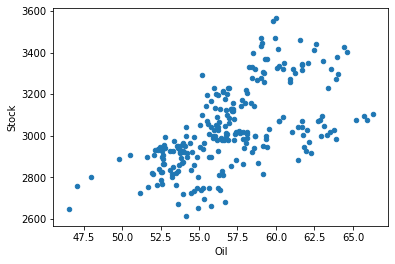

In [5]:
'''The following is an analysis of the relationship between WTI Oil price and Ecopetrol stock price on the same day.'''

print(pricetostock['Oil'].corr(pricetostock['Stock']))
pricetostock.plot.scatter(x='Oil',y='Stock')

In [6]:
#reshaping data

pricetostockshifted = pricetostock.copy()
pricetostockshifted['Stock'] = pricetostockshifted['Stock'].shift(-1)
pricetostockshifted.drop(pricetostockshifted.tail(1).index, inplace=True)

0.5473575603571312


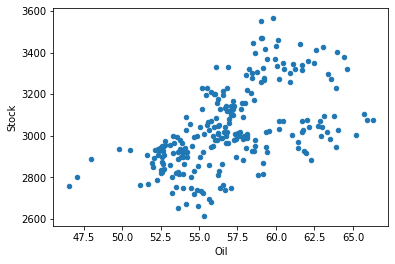

In [7]:
'''The following is an analysis of the relationship between the WTI Oil price in one day and the 
Ecopetrol stock price on the following day'''

print(pricetostockshifted['Oil'].corr(pricetostockshifted['Stock']))
pricetostockshifted.plot.scatter(x='Oil',y='Stock')

In [8]:
#reshaping data

pricetostockdiff = pricetostock.copy().diff()
pricetostockdiff.drop(pricetostockdiff.head(1).index,inplace=True)

0.43624533744193156


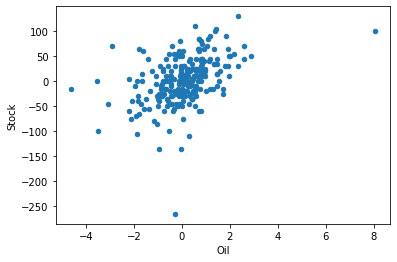

In [9]:
'''The following is an analysis of the relationship between the change in WTI Oil price on a daily interval and the 
change in Ecopetrol stock price on the corresponding dalily interval'''

print(pricetostockdiff['Oil'].corr(pricetostockdiff['Stock']))
pricetostockdiff.plot.scatter(x='Oil',y='Stock')

In [10]:
#reshaping data

pricetostockdiffshifted = pricetostockshifted.copy().diff()
pricetostockdiffshifted.drop(pricetostockdiffshifted.head(1).index, inplace=True)

-0.05209379816588648


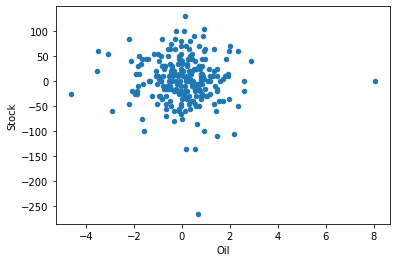

In [11]:
'''The following is an analysis of the relationship between the change in WTI Oil price on a daily interval and the 
change in Ecopetrol stock price on the consecutive dalily interval'''

print(pricetostockdiffshifted['Oil'].corr(pricetostockdiffshifted['Stock']))
pricetostockdiffshifted.plot.scatter(x='Oil',y='Stock')